This notebook attempts to provide the minimum framework necessary to perform a Hahn echo experiment using the CPMGProgram defined in `rfsoc.py`. We start by initializing the SoC and setting our channels. I'll assume we're using the first channel for both output and readout.

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
soc = QickSoc()

GEN_CH = 0
RO_CH = 0

Next we define our pulse generator class.

In [2]:
class CPMGProgram(AveragerProgram):
    def trigger_no_off(self, pins=None, t=0, rp=0, r_out=31):
        """
        Adapted from qick-dawg. Currently only used for digital I/O pins, so I removed the rest.
        Sets the specified pin high starting at time t, lasting until the end of the cycle.
        
        Method that is a slight modification of qick.QickProgram.trigger().
        This method does not turn off the PMOD pins, thus also does not require a width parameter

        Parameters
        ----------
        pins : list of int
            List of marker pins to pulsem, i.e. PMOD channels.
            Use the pin numbers in the QickConfig printout.
        adc_trig_offset : int, optional
            Offset time at which the ADC is triggered (in tProc cycles)
        t : int, optional
            The number of tProc cycles at which the ADC trigger starts
        rp : int, optional
            Register page
        r_out : int, optional
            Register number
        """
        if pins is None:
            pins = []
        if not pins:
            raise RuntimeError("must pulse at least one pin")
            
        outdict = defaultdict(int)
        for pin in pins:
            pincfg = self.soccfg['tprocs'][0]['output_pins'][pin]
            outdict[pincfg[1]] |= (1 << pincfg[2])

        t_start = t

        for outport, out in outdict.items():
            self.regwi(rp, r_out, out, f'out = 0b{out:>016b}')
            self.seti(outport, rp, r_out, t_start, f'ch =0 out = ${r_out} @t = {t}')
            #self.seti(outport, rp, 0, t_end, f'ch =0 out = 0 @t = {t}')


    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]
        
        # Convert frequently-used times from us to cycles
        readout_length = [self.us2cycles(cfg["readout_length"], ro_ch=ch) for ch in cfg["ro_chs"]]
        length = self.us2cycles(cfg["pulse1_1"]/1000, gen_ch=res_ch)
        delay = self.us2cycles(cfg['delay']/1000-cfg['pulse1_1']/1000)
        tpi2 = self.us2cycles(cfg['pulse1_1']/1000)
        tstart = self.us2cycles(cfg['nutation_delay']/1000)

        # set the nyquist zone
        self.declare_gen(ch=res_ch, nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for n, ch in enumerate(cfg["ro_chs"]):
            self.declare_readout(ch=ch, length=readout_length[n],
                                 freq=cfg["freq"], gen_ch=res_ch)

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])

        # set our output to be the default pulse register
        self.default_pulse_registers(ch=res_ch, style="const", freq=freq)
        
        self.synci(200)  # give processor some time to configure pulses


    def cpmg(self, ph1, ph2, phdel=0, pulses=1, tstart=0):
        """
        Runs a Carr-Purcell pulse sequence with optional nutation pulse
        """
        # Set relevant times
        res_ch = self.cfg["res_ch"]
        tpi2 = self.cfg["pulse1_1"]/1000
        tpi = self.cfg["pulse1_2"]/1000
        delay = self.cfg["delay"]/1000
        delay_pi2 = delay-tpi2
        delay_pi = 2*delay-tpi
        nutwidth = self.cfg["nutation_length"]/1000
        nutdelay = self.cfg["nutation_delay"]/1000
        gain = self.cfg["gain"]
        
        # We want half the power for our pi/2 pulse, and this achieves that
        gain2 = gain if gain<10000 else gain-10000
        
        # In Loopback mode we want to start readout at the beginning of the pi/2 pulse
        # Otherwise we want to delay readout until the echo location
        offset = 0 if self.cfg["loopback"] else delay+(2*pulses-1)*delay#+(pulses-1)*(delay_pi)
        # Actually set the trigger offset, including empirically-determined delay of 0.25 us
        trig_offset = self.us2cycles(0.25+nutwidth+self.cfg["h_offset"]+offset)
        
        # If the nutation pulse width is greater than the minimum number of cycles, add it in
        nut_length = self.us2cycles(nutwidth, gen_ch=res_ch)
        if nut_length>2:
            self.set_pulse_registers(ch=self.cfg["res_ch"], gain=gain, phase=90, length=nut_length)
            self.pulse(ch=self.cfg["res_ch"])
        
        # Wait the nutation delay time
        self.synci(self.us2cycles(nutdelay))
        
        # Tell the ADC when to trigger readout, based on the trigger offset defined above
        # If you uncomment the pins argument, it will also send a pulse on an I/O pin
        self.trigger(adcs=self.ro_chs,
                    # pins=[0],
                    adc_trig_offset=trig_offset)

        # pi/2 pulse
        self.set_pulse_registers(ch=res_ch, gain=gain2, phase=ph1,
                                 length=self.us2cycles(tpi2, gen_ch=res_ch))
        self.pulse(ch=res_ch)
        
        # Delay between pi/2 and pi pulses
        self.synci(self.us2cycles(delay_pi2))
        
        # Add a configurable number of pi pulses, along with delays.
        # delay_pi is roughly twice delay_pi2, as the delay between pi pulses should be
        for n in np.arange(pulses):
            self.set_pulse_registers(ch=res_ch, gain=gain, phase=ph2,
                                     length=self.us2cycles(tpi, gen_ch=res_ch))
            self.pulse(ch=self.cfg["res_ch"])

            self.synci(self.us2cycles(delay_pi))

        self.synci(self.us2cycles(delay_pi))
        
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["period"]))
        

    def body(self):
        # Start the pin output (to close the switch connecting my board to the cryostat)
        # Then wait a short time to make sure it has actually closed before pulsing
        self.trigger_no_off(pins=[0])
        self.synci(self.us2cycles(0.1))
        # Do the pulses
        self.cpmg(0, 0, 0, self.cfg["pulses"])

In [3]:
parameters = {
    'res_ch': GEN_CH,
    'ro_chs': [RO_CH],
    'reps': 1,
    'freq': 3902.0,
    'delay': 50.0,
    'period': 20.0,
    'cpmg': 1,
    'nutation_delay': 5000.0,
    'h_offset': -0.1,
    'pulse1_1': 20.0,
    'pulse1_2': 20.0,
    'readout_length': 0.3,
    'gain': 32500,
    'pulses': 1,
    'nutation_length': 0.0,
    'soft_avgs': 100,
    'single': False,
    'loopback': False
}

In [4]:
prog = CPMGProgram(soc, parameters)
iq_list = prog.acquire_decimated(soc, progress=True)

  0%|          | 0/100 [00:00<?, ?it/s]

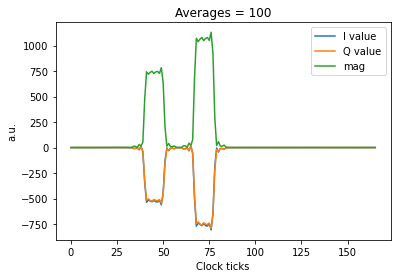

In [5]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value")
    plt.plot(iq[1], label="Q value")
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(parameters["soft_avgs"]))
plt.legend();